# Exercise 3.1
Welcome to Exercise 3. Again in the first two cells we are providing a connection to Cloudant/ApacheCouchDB to obtain a data frame for your test data. Now we will do some visualizations.

### TODO Please provide your Cloudant credentials here

In [1]:
hostname = "5b6b1985-6dc3-4917-aeb1-6fcae5384198-bluemix.cloudant.com"
user = "5b6b1985-6dc3-4917-aeb1-6fcae5384198-bluemix"
pw = "05ef0a659b1dc920991fb4884929c9e3cb6194a1ed8bccb76f2ef0565d2a2a8e"
database = "washing" #as long as you didn't change this in the NodeRED flow the database name stays the same

In [2]:
spark = SparkSession\
    .builder\
    .appName("Cloudant Spark SQL Example in Python using temp tables")\
    .config("cloudant.host",hostname)\
    .config("cloudant.username", user)\
    .config("cloudant.password",pw)\
    .getOrCreate()


In [3]:
#Please don't modify this function
def readDataFrameFromCloudant(database):
    cloudantdata=spark.read.load(database, "org.apache.bahir.cloudant")

    cloudantdata.createOrReplaceTempView("washing")
    spark.sql("SELECT * from washing").show()
    return cloudantdata

In [4]:
cloudantdata=readDataFrameFromCloudant(database)

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0a79ae01187f3f227...|1-ec38d95c7b883ff...|    7|      11|acceptable|     null|      75| null|         92|1540698014385|   null|
|0a79ae01187f3f227...|1-902a7cf2a308db1...|   11|      11|acceptable|     null|      76| null|         98|1540698018389|   null|
|0a79ae01187f3f227...|1-ffb500185c8e7b1...|   18|      11|acceptable|     null|      72| null|         89|1540698025400|   null|
|0a79ae01187f3f227...|1-3da5859a4621152...|    8|    null|      null|       69|    null| null|       null|1540698031386|    233|
|0a79ae01187f3f227...|1-8e4955a5b79b6f3...|   31|      11|acceptable|     null|      78| null|   

So let's check how may rows we have got

In [5]:
cloudantdata.count()

414

Now we register the data frame in the ApacheSparkSQL catalog so that we can query it using SQL

In [6]:
cloudantdata.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0a79ae01187f3f227...|1-ec38d95c7b883ff...|    7|      11|acceptable|     null|      75| null|         92|1540698014385|   null|
|0a79ae01187f3f227...|1-902a7cf2a308db1...|   11|      11|acceptable|     null|      76| null|         98|1540698018389|   null|
|0a79ae01187f3f227...|1-ffb500185c8e7b1...|   18|      11|acceptable|     null|      72| null|         89|1540698025400|   null|
|0a79ae01187f3f227...|1-3da5859a4621152...|    8|    null|      null|       69|    null| null|       null|1540698031386|    233|
|0a79ae01187f3f227...|1-8e4955a5b79b6f3...|   31|      11|acceptable|     null|      78| null|   

So let's visualize voltage using a box plot to get an idea on the value distribution of this parameter. First, we have to create a python list. Make sure you use the sample function in order to not blast your spark driver or plotting library. 

In [7]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[238, 235, 238, 226, 238, 228]

Now we have to activate the notebook to show the plots directly under the cell

In [8]:
%matplotlib inline

Now it's time to plot the python list by importing the matplotlib library, calling "boxplot" and "show". Note that you can see mean (red line) around 230. Then you see that 50% of all values are between 225 and 235 (blue box). Per default values up to 250 are not seen as outliers (little, black horizontal line). And the "plus" symbols on top are definitely outliers. Congratulations, you've written your first anomaly detection algorithm. Unfurtunately you still need a brain attached to it, so we'll cover on how we write one without a brain needed in the next course. And in the course after that we'll even tell you how to implement a artificial brain to further improve it, so stay tuned :)

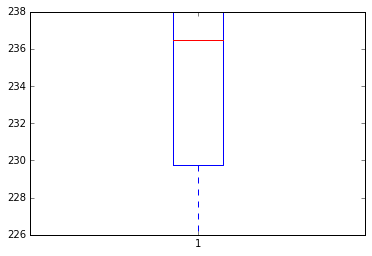

In [9]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

Since we are dealing with time series data we want to make use of the time dimension as well. The least complex plots are run charts where the time domain (dimension) is represented at the horizontal x-axis and the y-axis shows the actual sensor value. Let's do this for voltage as well. 

In [10]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda (ts,voltage): ts).collect()
result_array_voltage = result_rdd.map(lambda (ts,voltage): voltage).collect()
print result_array_ts[:15]
print result_array_voltage[:15]

[1540698070415, 1540698091427, 1540698226510, 1540698229511, 1540698249272, 1540698252275, 1540698258279, 1540698264285, 1540698267289]
[236, 229, 231, 228, 231, 223, 228, 236, 230]


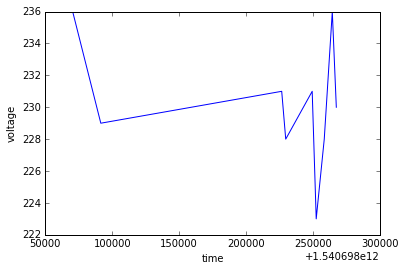

In [11]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

But this time we want to only plot data worth of one hour. Therefore we first have to find out in which date range we have data available:

In [12]:
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1540698008369|1540698279405|
+-------------+-------------+



Now lets repeat the previous steps but only show data for hour. We've found out the low and high boundary of data available and we know that "ts" stand for "timestamp". Timestamp are the number of millisecons passed since the 1st of Jan. 1970. You can also use an online tool like http://www.epochconverter.com/ to convert these. But for now just an interval of 60 minutes (1000*60*60)=3600000 within the range above (note that we have removed the sample function because the data set is already reduced)

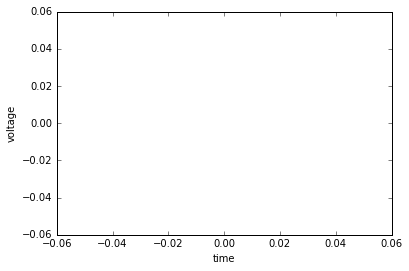

In [13]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1480423383507 and
    ts <= 1480423383507+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda (ts,voltage): ts).collect()
result_array_voltage = result_rdd.map(lambda (ts,voltage): voltage).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

As you can see we are not only able to spot the outliers but also see a time pattern of these outliers occuring which can be used for further downstream analysis. Again your brain was already capable of spotting the pattern. In the next two coursera courses we will teach a machine to spot those patterns as well.

Now we've plotted a maximum of two dimensions at a time, let's go for three in a so-called 3D scatter plot. Again we have to create python lists (with applied sampling if necessary) from three properties of our data.

In [14]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.temperature))
result_array_hardness = result_rdd.map(lambda (hardness,temperature,flowrate): hardness).collect()
result_array_temperature = result_rdd.map(lambda (hardness,temperature,flowrate): temperature).collect()
result_array_flowrate = result_rdd.map(lambda (hardness,temperature,flowrate): flowrate).collect()

Once done it is very simple to import the necessary library and create a scatter plot

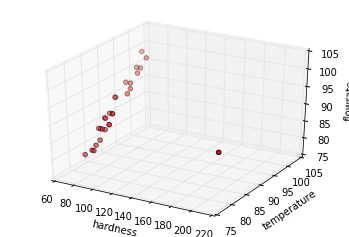

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

You will notice that the individual points resemble in some sort of plane. But this is not a surprise. Actually we can draw the following conclusions from the plot:

- most of the data points are lying around hardness 60-80, temperature 80-100 and flowrate 80-100
- there are some outliers, especially when it comes to the range of hardness 100-200
- the data follows some narrow boundaries

So lets double-check what's going on with hardness since it seems that it really sticks around 60-80 and very seldom creates values above that. We can use a histogram for that which bins together certain value ranges and counts the frequency of occurences of values within this range. Those frequencies are ordered and shown as a bar diagram, so let's plot it:

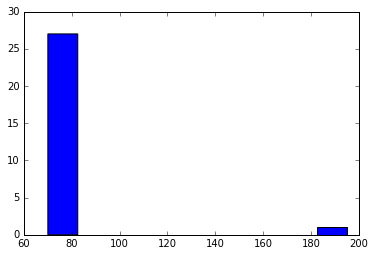

In [16]:
plt.hist(result_array_hardness)
plt.show()

Our assumpion was correct, nearly all values are around 60-80 with very less values about that threshold.
This concludes Exercice 3.1.